In [3]:
import sys

import numpy as np

sys.path.append("lib")
import pickle

import numpy as np
import yaml
from astropy.timeseries import BoxLeastSquares
from scipy.interpolate import BSpline, splrep
from wotan import flatten


def bls(time, flux, error):
    model = BoxLeastSquares(time, flux, dy=error)
    return model.power(periods, 0.03, objective="snr")


def save_result(trend, results, filename):
    t0 = 0.0
    i = np.argmax(results.power)
    period = results.period[i]
    power = results.power

    pickle.dump(
        {
            "t0": t0,
            "period": period,
            "power": power,
            "trend": trend,
            "snr": power[i],
        },
        open(filename, "wb"),
    )

tic = 396088793
data = pickle.load(open(f"../data/{tic}/injected/15.fluxes", "rb"))
periods = np.load(f"../data/{tic}/periods.npy")
info = yaml.safe_load(open(f"../data/{tic}/info.yaml", "r"))

time, flux, error = data["time"], data["flux"], data["error"]
verbose = True

# biweight
# --------

flatten_trend = flatten(
    time,
    flux,
    window_length=data["transit_duration"] * 3,
    return_trend=True,
    robust=True,
)[1]

flatten_flux = flux - flatten_trend
flatten_flux -= np.mean(flatten_flux)
flatten_flux += 1.0

results = bls(time, flatten_flux, error)

# save_result(flatten_trend, results, snakemake.output.wotan3D)


# harmonics
# ---------


# makes an harmonics design matrix of time
def make_harmonics(time, period, nharmonics=4):
    # make design matrix
    X = np.ones((len(time), 2 * nharmonics + 1))
    X[:, 1] = time
    for i in range(1, nharmonics):
        X[:, 2 * i + 1] = np.sin(2 * np.pi * i * time / period)
        X[:, 2 * i + 2] = np.cos(2 * np.pi * i * time / period)

    return X


X = make_harmonics(time, info["star_period"], nharmonics=5)
# solve for the coefficients
coeffs = np.linalg.solve(X.T @ X, X.T @ flux)
# make the model
flatten_trend = X @ coeffs
flatten_flux = flux - flatten_trend
flatten_flux -= np.mean(flatten_flux)
flatten_flux += 1.0

results = bls(time, flatten_flux, error)

save_result(flatten_trend, results, snakemake.output.harmonics)

# bspline
mask = np.ones_like(data["time"], dtype=bool)

for i in range(2):
    tck = splrep(
        time[mask],
        flux[mask],
        w=1 / error[mask],
    )
    trend = BSpline(*tck)(time)
    mask &= np.abs(flux - trend) < 3 * np.std(flux - trend)

trend = BSpline(*tck)(time)

flatten_trend = BSpline(*tck)(time)
flatten_flux = flux - flatten_trend
flatten_flux -= np.mean(flatten_flux)
flatten_flux += 1.0

results = bls(time, flatten_flux, error)

# save_result(flatten_trend, results, snakemake.output.bspline)


# bens
# ----


def bens_detrend(time, flux, n=5):
    def rotation_period(time, flux):
        """rotation period based on LS periodogram"""
        from astropy.stats import LombScargle

        ls = LombScargle(time, flux)
        frequency, power = ls.autopower(
            minimum_frequency=1 / 5, maximum_frequency=1 / 0.1
        )
        period = 1 / frequency[np.argmax(power)]
        return period

    def subtract_sinusoid(time, flux, period):
        X = np.vstack(
            [
                np.ones(len(time)),
                np.cos(2 * np.pi / period * time),
                np.sin(2 * np.pi / period * time),
            ]
        ).T

        w = np.linalg.lstsq(X, flux, rcond=None)[0]
        model = np.dot(X, w)

        return flux - model, model

    _flux = flux.copy()
    model = np.zeros_like(flux)

    for _ in range(n):
        period = rotation_period(time, _flux)
        _flux, _model = subtract_sinusoid(time, _flux, period)
        model += _model

    return _flux + 1.0, model


flatten_flux, flatten_trend = bens_detrend(time, flux, n=8)

results = bls(time, flatten_flux, error)

# save_result(flatten_trend, results, snakemake.output.bens)


LinAlgError: Singular matrix

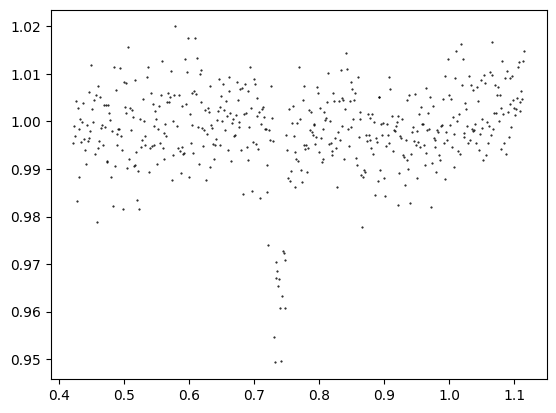

In [5]:
import matplotlib.pyplot as plt

plt.plot(time, flux, "k.", ms=1)